# Title: Metric Benchmark Analysis
### Purpose: Snippets to do a thing
### Author: @mjz



## Global imports and notebook setup here

In [1]:
%matplotlib inline

#------ python libs ----------
import logging
import os
SEP = os.path.sep
import sys
import uuid
import pathlib

#------ notebook libs ----------
import matplotlib.pyplot as plt
import networkx as nx
import graphviz
import IPython.display
import numpy as np
import scipy.stats as st
import scipy.special
import pandas as pd
# # bokeh plotting setup
# import bokeh.io
# import bokeh.plotting
# import bokeh.application
# import bokeh.application.handlers
# bokeh.io.output_notebook()
# notebook_url = 'localhost:8888'

#------ data connectors ----------
proj = 'cloud-performance-tool'
ds = 'test_notebook_bq'
tab = 'test1'
bq_tbl = r'{}.{}.{}'.format(proj, ds, tab)
# tbl2_full = '`cloud-performance-tool.test_notebook_bq.test2`'
# key_loc = '/home/toor/.google/smu-benchmarking-7de5dd11902f.json'
key_loc = '/opt/projects/google/pkb_autopilot/playbooks/roles/pkb/templates/service_key.json'

# -- bq --
from google.cloud import bigquery
from pandas.io.gbq import read_gbq as qdf
# %reload_ext google.cloud.bigquery # %%bigquery df
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = key_loc # bq_client needs this (svc_acct auth)
os.environ['PROJECT_ID'] = proj
bigquery_client = bigquery.Client(project=proj) # 

# -- influx--
# from influxdb import InfluxDBClient
# from influxdb import DataFrameClient
# client = InfluxDBClient('192.168.0.115', '8086')
# dbs = client.get_list_database()
# -- mongo--
# import pymongo 
# from pymongo import MongoClient
# client = MongoClient('localhost', 27017)
# print(client.list_database_names())


#------ project libs ----------
py_mulval_path = r'/opt/projects/diss/py-mulval/src'
sys.path.append(py_mulval_path)

# Just importing for their flags right now
import py_mulval.py_mulval as py_mulval
import py_mulval.boromir as boromir
import py_mulval.log_util as log_util
import py_mulval.mulpy as mulpy
import py_mulval.metrics as secmet
import py_mulval.attack_graph as attack_graph

from py_mulval import flags
FLAGS = flags.FLAGS
FLAGS([sys.argv[0]]) # dont expect cli args from jupyter

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')



In [2]:
# Show an attack graph in this notebook
def plot_dot(g, title=None):
    A = nx.nx_agraph.to_agraph(g)
    if title:
        A.graph_attr.update(label=title, labelloc='top', labeljust='center', fontsize=24)
    # A.layout('dot', args='-Nfontsize=10 -Nwidth=".2" -Nheight=".2" -Nmargin=0 -Gfontsize=8')
    args = """
    -Gsize=17
    -Nfontname=Roboto
    -Efontname=Roboto
    -Nfontsize=14
    -Efontsize=14
    """
    A.layout('dot', args=args )
    # A.draw(self.outputDir + '/' + outfilename)
    A.draw()
    # plt.show()
    return graphviz.Source(A.to_string())

## Background Info


## Setup Boromir

In [3]:
# cmd_vals = [
proj = 'cloud-performance-tool'
ds = 'test_notebook_bq'
tab = 'test2'
gorando = True
runcount = '100'
benchmarks = 'mttf'
benchmark_config_file='mttf.yml'
# ]

cmd = '/opt/projects/diss/py-mulval/src/run_boromir.py '
cmd_args = [
#     '--dry_run',    
    '--boromir_run_count={runcount}', 
    '--secmet_random_cvss_score={gorando}',
#     '--benchmarks={benchmarks}',
#      '--benchmark_config_file={benchmark_config_file}',
    '--bigquery_table={project_id}:{dataset}.{table}'
    ] 

full_cmd = cmd + " ".join(cmd_args)
full_cmd = full_cmd.format(project_id=proj, dataset=ds, table=tab, runcount=runcount, benchmarks=benchmarks, benchmark_config_file=benchmark_config_file, gorando=gorando)
!echo {full_cmd}


/opt/projects/diss/py-mulval/src/run_boromir.py --boromir_run_count=100 --secmet_random_cvss_score=True --bigquery_table=cloud-performance-tool:test_notebook_bq.test2


### Run Boromir

In [4]:
!echo {full_cmd}
! {full_cmd} # <--- uncomment this to run

/opt/projects/diss/py-mulval/src/run_boromir.py --boromir_run_count=100 --secmet_random_cvss_score=True --bigquery_table=cloud-performance-tool:test_notebook_bq.test2
2020-05-13 20:50:47,018 aa5ea693 MainThread INFO     Verbose logging to: /tmp/mulpy/runs/aa5ea693/boromir.log
2020-05-13 20:50:47,019 aa5ea693 MainThread INFO     PerfKitBenchmarker version: unknown
2020-05-13 20:50:47,019 aa5ea693 MainThread INFO     Flag values:
--bigquery_table=cloud-performance-tool:test_notebook_bq.test2
--secmet_random_cvss_score
--boromir_run_count=100
2020-05-13 20:50:47,033 aa5ea693 MainThread INFO     Running: ssh-keygen -t rsa -N  -m PEM -q -f /tmp/mulpy/runs/aa5ea693/py_mulval_keyfile
2020-05-13 20:50:47,196 aa5ea693 MainThread INFO     Setting --max_concurrent_threads=200.
2020-05-13 20:50:47,318 aa5ea693 MainThread metf_tm(1/9) INFO     Provisioning resources for benchmark metf_tm
2020-05-13 20:50:47,318 aa5ea693 MainThread metf_tm(1/9) INFO     Preparing benchmark metf_tm
2020-05-13 20:50:4

### query all metrics in a run

In [15]:
query = r"""
select
# SELECT thedate, sample_uri, test, value, metric,
#SELECT sample_uri, reduced_ag, value, orig_ag, fact_graph,
#metric,

# -- unit, citation, cite_key, metric, metric_name, metric_summary, metric_usage, 
# labels,
# reduced_ag, orig_ag, fact_graph
#FROM (
#  SELECT
#     value,
    TIMESTAMP_MICROS(CAST(timestamp * 1000000 AS int64)) AS thedate,
    test, value, unit, labels, metric, run_uri, sample_uri,
    REGEXP_EXTRACT(labels, r'\|cite_key:(.*?)\|') AS cite_key,
    REGEXP_EXTRACT(labels, r'\|metric_name:(.*?)\|') AS metric_name,
    REGEXP_EXTRACT(labels, r'(?s)\|metric_summary:(.*?)\|') AS metric_summary,
    REGEXP_EXTRACT(labels, r'(?s)\|metric_usage:(.*?)\|') AS metric_usage,
    REGEXP_EXTRACT(labels, r'(?s)\|attack_graph_reduced:(.*?)\|') AS reduced_ag,
    REGEXP_EXTRACT(labels, r'(?s)\|attack_graph_orig:(.*?)\|') AS orig_ag,
    REGEXP_EXTRACT(labels, r'(?s)\|facts_graph:(.*?)\|') AS fact_graph,

  FROM
    {}
   #WHERE
     #test = 'mttf'
     #AND metric = 'mttf' 
    # run_uri = 'aa5ea693'
#      order by timestamp asc
#      limit 1
#     ) 
""".format(bq_tbl)
# print(query)
df=qdf(query,  project_id=proj)
df.describe()

Downloading: 100%|██████████| 10486/10486 [00:06<00:00, 1531.85rows/s]


,value
count,10486.000000
mean,17.118938
std,74.476312
min,-1.000000
25%,0.039064
50%,0.062307
75%,28.520200
max,5007.020000


In [16]:
df.head()

,thedate,test,value,unit,labels,metric,run_uri,sample_uri,cite_key,metric_name,metric_summary,metric_usage,reduced_ag,orig_ag,fact_graph
0,2020-05-13 21:56:46.992605+00:00,mttf,52.033500,weeks,|attack_graph_orig:digraph G {\n\tgraph [name=...,mttf,358375c2,3b465a66-9faf-4608-9f30-f5f1cb8a492b,dacier1996,mttf,None,None,digraph G {\n\tgraph [name=G];\n\t1\t [color=b...,digraph G {\n\tgraph [name=G];\n\t1\t [color=b...,digraph input {\n\tgraph [name=input];\n\twebS...
1,2020-05-13 21:56:47.047703+00:00,mttf,52.033500,weeks,|attack_graph_orig:digraph G {\n\tgraph [name=...,mttf,358375c2,5d5cb21b-2b90-4888-844c-be4f41f9c2b7,dacier1996,mttf,None,None,digraph G {\n\tgraph [name=G];\n\t1\t [color=b...,digraph G {\n\tgraph [name=G];\n\t1\t [color=b...,digraph input {\n\tgraph [name=input];\n\twebS...
2,2020-05-13 21:56:46.993638+00:00,mttf,0.263537,seconds,,End to End Runtime,358375c2,b1466974-e14b-489b-9761-9d7ba664d536,None,None,None,None,None,None,None
3,2020-05-13 21:56:47.048295+00:00,mttf,0.036622,seconds,,End to End Runtime,358375c2,b6b2eb4d-14bc-4d4f-9d6c-14968af95238,None,None,None,None,None,None,None
4,2020-05-13 22:01:47.610652+00:00,num_paths,2.000000,paths,"|all_paths_original:[[""18"", ""16"", ""15"", ""14"", ...",num_paths,635c2038,92b876ec-fb29-49fb-be7e-8fbae48fc07a,Ortalo1999,num_paths,None,None,None,digraph G {\n\tgraph [name=G];\n\t1\t [color=b...,digraph input {\n\tgraph [name=input];\n\tinte...


In [17]:
df.shape

(10486, 15)

In [18]:
grouped =df.groupby(['metric'])
grouped.describe()

value                                       \
                           count         mean        std          min   
metric                                                                  
End to End Runtime        5243.0     0.042467   0.015231     0.022897   
epl                          2.0    -1.000000   0.000000    -1.000000   
metf_ml                      2.0     0.616000   0.000000     0.616000   
metf_tm                      2.0     0.616000   0.000000     0.616000   
mttf                      5227.0    32.325443  32.678830     0.000186   
nra_amc                      2.0    -1.000000   0.000000    -1.000000   
num_paths                    2.0     2.000000   0.000000     2.000000   
probpath                     2.0    -1.000000   0.000000    -1.000000   
shortest_path_cumulative     2.0   153.467000   0.000000   153.467000   
shortest_path_direct         2.0  5007.020000   0.000000  5007.020000   

                                                                              
                                  25%          50%          75%          max  
metric                                                                        
End to End Runtime           0.033361     0.040571     0.047548     0.377221  
epl                         -1.000000    -1.000000    -1.000000    -1.000000  
metf_ml                      0.616000     0.616000     0.616000     0.616000  
metf_tm                      0.616000     0.616000     0.616000     0.616000  
mttf                         2.000400    30.030200    52.033500   200.000000  
nra_amc                     -1.000000    -1.000000    -1.000000    -1.000000  
num_paths                    2.000000     2.000000     2.000000     2.000000  
probpath                    -1.000000    -1.000000    -1.000000    -1.000000  
shortest_path_cumulative   153.467000   153.467000   153.467000   153.467000  
shortest_path_direct      5007.020000  5007.020000  5007.020000  5007.020000

## EPL 

### Validation

In [9]:
# all vulns fixed from 0-10 stepping .1 (100 samples)
# cmd_vals = [
proj = 'cloud-performance-tool'
ds = 'test_notebook_bq'
tab = 'test2'

time_phases='runtimes,end_to_end_runtime' # 'runtimes,timestamps,end_to_end_runtime,none'
gorando = True
cvss_score=4.2
runcount = '100'
benchmarks = 'epl'
benchmark_config_file='epl_step_cvss_100.yml'
# ]

cmd = '/opt/projects/diss/py-mulval/src/run_boromir.py '
cmd_args = [
#     '--dry_run',    
      '--timing_measurements={time_phases}',
#     '--boromir_run_count={runcount}', 
#     '--secmet_random_cvss_score={gorando}',
#     '--secmet_fix_cvss_score={cvss_score}'
    '--benchmarks={benchmarks}',
     '--benchmark_config_file={benchmark_config_file}',
    '--bigquery_table={project_id}:{dataset}.{table}'
    ] 

full_cmd = cmd + " ".join(cmd_args)
full_cmd = full_cmd.format(project_id=proj, dataset=ds, table=tab, runcount=runcount, benchmarks=benchmarks, benchmark_config_file=benchmark_config_file, 
                           gorando=gorando, cvss_score=cvss_score, time_phases=time_phases)
!echo {full_cmd}


/opt/projects/diss/py-mulval/src/run_boromir.py --timing_measurements=runtimes,end_to_end_runtime --benchmarks=epl --benchmark_config_file=epl_step_cvss_100.yml --bigquery_table=cloud-performance-tool:test_notebook_bq.test2


In [19]:
! {full_cmd} # <----- uncomment to run

2020-05-13 20:59:44,887 058e72f7 MainThread INFO     Verbose logging to: /tmp/mulpy/runs/058e72f7/boromir.log
2020-05-13 20:59:44,887 058e72f7 MainThread INFO     PerfKitBenchmarker version: unknown
2020-05-13 20:59:44,887 058e72f7 MainThread INFO     Flag values:
--timing_measurements=runtimes,end_to_end_runtime
--benchmark_config_file=epl_step_cvss_100.yml
--bigquery_table=cloud-performance-tool:test_notebook_bq.test2
--benchmarks=epl
2020-05-13 20:59:44,900 058e72f7 MainThread INFO     Running: ssh-keygen -t rsa -N  -m PEM -q -f /tmp/mulpy/runs/058e72f7/py_mulval_keyfile
2020-05-13 20:59:44,959 058e72f7 MainThread INFO     Setting --max_concurrent_threads=200.
2020-05-13 20:59:46,358 058e72f7 MainThread epl(1/101) INFO     Provisioning resources for benchmark epl
2020-05-13 20:59:46,358 058e72f7 MainThread epl(1/101) INFO     Preparing benchmark epl
2020-05-13 20:59:46,359 058e72f7 MainThread epl(1/101) ERROR    Writing MulVal source model from /opt/projects/diss/py-mulval/src/py_mu

In [43]:
run_uri='058e72f7'
query = r"""
select
# SELECT thedate, sample_uri, test, value, metric,
#SELECT sample_uri, reduced_ag, value, orig_ag, fact_graph,
#metric,

# -- unit, citation, cite_key, metric, metric_name, metric_summary, metric_usage, 
# labels,
# reduced_ag, orig_ag, fact_graph
#FROM (
#  SELECT
#     value,
    TIMESTAMP_MICROS(CAST(timestamp * 1000000 AS int64)) AS thedate,
    test, value, unit, labels, metric, run_uri, sample_uri,
    REGEXP_EXTRACT(labels, r'\|cite_key:(.*?)\|') AS cite_key,
    REGEXP_EXTRACT(labels, r'\|metric_name:(.*?)\|') AS metric_name,
    REGEXP_EXTRACT(labels, r'(?s)\|metric_summary:(.*?)\|') AS metric_summary,
    REGEXP_EXTRACT(labels, r'(?s)\|metric_usage:(.*?)\|') AS metric_usage,
    REGEXP_EXTRACT(labels, r'(?s)\|attack_graph_reduced:(.*?)\|') AS reduced_ag,
    REGEXP_EXTRACT(labels, r'(?s)\|attack_graph_orig:(.*?)\|') AS orig_ag,
    REGEXP_EXTRACT(labels, r'(?s)\|facts_graph:(.*?)\|') AS fact_graph,
    REGEXP_EXTRACT(labels, r'(?s)\|secmet_fix_cvss_score:(.*?)\|') AS fixed_score,

  FROM
    `{project_id}.{dataset}.{table}`
   WHERE
     #test = 'mttf'
     #AND metric = 'mttf' 
     run_uri = '{run_uri}'
#      order by timestamp asc
#      limit 1
#     ) 
""".format(project_id=proj, dataset=ds, table=tab, run_uri=run_uri)
# print(query)
df_epl=qdf(query,  project_id=proj)
df_epl.describe()

Downloading: 100%|██████████| 707/707 [00:00<00:00, 918.73rows/s]


,value
count,7.070000e+02
mean,6.605868e-01
std,1.581586e+00
min,9.536743e-07
25%,1.049042e-05
50%,6.665230e-03
75%,4.545152e-02
max,7.000000e+00


In [44]:
df_epl.head()

,thedate,test,value,unit,labels,metric,run_uri,sample_uri,cite_key,metric_name,metric_summary,metric_usage,reduced_ag,orig_ag,fact_graph,fixed_score
0,2020-05-14 01:59:46.655308+00:00,epl,4.5,days,|attack_graph_orig:digraph G {\n\tgraph [name=...,epl,058e72f7,c4d769ad-acf6-429f-95e0-01a80d140f0b,Abraham2014,epl,None,None,digraph G {\n\tgraph [name=G];\n\t1\t [color=b...,digraph G {\n\tgraph [name=G];\n\t1\t [color=b...,digraph input {\n\tgraph [name=input];\n\twork...,0.1
1,2020-05-14 01:59:46.700452+00:00,epl,4.5,days,|attack_graph_orig:digraph G {\n\tgraph [name=...,epl,058e72f7,7f67c174-7d0b-4e9d-ac6f-1829d2fe9458,Abraham2014,epl,None,None,digraph G {\n\tgraph [name=G];\n\t1\t [color=b...,digraph G {\n\tgraph [name=G];\n\t1\t [color=b...,digraph input {\n\tgraph [name=input];\n\twork...,0.2
2,2020-05-14 01:59:46.743474+00:00,epl,4.5,days,|attack_graph_orig:digraph G {\n\tgraph [name=...,epl,058e72f7,bd61563e-ec72-4368-9a9c-c08681b32eca,Abraham2014,epl,None,None,digraph G {\n\tgraph [name=G];\n\t1\t [color=b...,digraph G {\n\tgraph [name=G];\n\t1\t [color=b...,digraph input {\n\tgraph [name=input];\n\twork...,0.3
3,2020-05-14 01:59:46.788091+00:00,epl,4.5,days,|attack_graph_orig:digraph G {\n\tgraph [name=...,epl,058e72f7,475e4233-ec91-41c7-939f-405c9916d373,Abraham2014,epl,None,None,digraph G {\n\tgraph [name=G];\n\t1\t [color=b...,digraph G {\n\tgraph [name=G];\n\t1\t [color=b...,digraph input {\n\tgraph [name=input];\n\twork...,0.4
4,2020-05-14 01:59:46.833258+00:00,epl,4.5,days,|attack_graph_orig:digraph G {\n\tgraph [name=...,epl,058e72f7,5f1df0b5-74c3-4ec6-be76-4ab074ad713d,Abraham2014,epl,None,None,digraph G {\n\tgraph [name=G];\n\t1\t [color=b...,digraph G {\n\tgraph [name=G];\n\t1\t [color=b...,digraph input {\n\tgraph [name=input];\n\twork...,0.5


In [49]:
print(df_epl['reduced_ag'].unique().shape, df_epl.dtypes)
# df_epl['orig_ag'].unique().shape

(102,) thedate           datetime64[ns, UTC]
test                           object
value                         float64
unit                           object
labels                         object
metric                         object
run_uri                        object
sample_uri                     object
cite_key                       object
metric_name                    object
metric_summary                 object
metric_usage                   object
reduced_ag                     object
orig_ag                        object
fact_graph                     object
fixed_score                    object
dtype: object


In [51]:
df_epl['fixed_score'] = df_epl['fixed_score'].astype(float)

(1, 1)


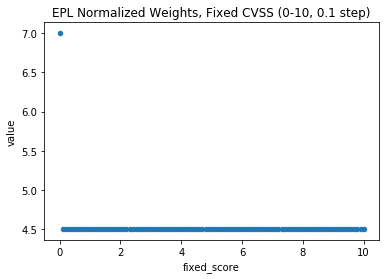

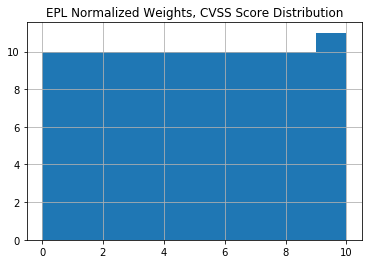

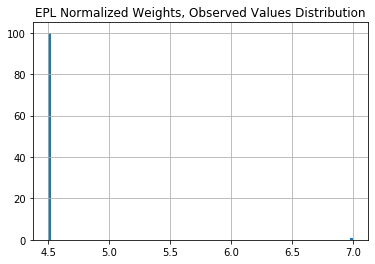

In [108]:
df_eplvals = df_epl[df_epl.metric=='epl']
ax1 = df_eplvals.plot('fixed_score', 'value', kind='scatter', title="EPL Normalized Weights, Fixed CVSS (0-10, 0.1 step)")
# ax1 = df_eplunnorm_vals.plot('fixed_score', 'value', kind='scatter', title="EPL UnWeighted, Fixed CVSS (0-10, 0.1 step)")
# fig, 
ax2 = df_eplvals.hist('fixed_score' )
print(ax2.shape)
ax2[0][0].title.set_text('EPL Normalized Weights, CVSS Score Distribution')

ax3 = df_eplvals.hist('value', bins=100)
ax3[0][0].title.set_text('EPL Normalized Weights, Observed Values Distribution')

In [66]:
# --benchmarks=epl_unnorm --benchmark_config_file=eplunnorm_step_cvss_100.yml

# all vulns fixed from 0-10 stepping .1 (100 samples)
# cmd_vals = [
proj = 'cloud-performance-tool'
ds = 'test_notebook_bq'
tab = 'test2'

time_phases='runtimes,end_to_end_runtime' # 'runtimes,timestamps,end_to_end_runtime,none'
gorando = True
cvss_score=4.2
runcount = '100'
benchmarks = 'epl_unnorm'
benchmark_config_file='eplunnorm_step_cvss_100.yml'
# ]

cmd = '/opt/projects/diss/py-mulval/src/run_boromir.py '
cmd_args = [
#     '--dry_run',    
      '--timing_measurements={time_phases}',
#     '--boromir_run_count={runcount}', 
#     '--secmet_random_cvss_score={gorando}',
#     '--secmet_fix_cvss_score={cvss_score}'
    '--benchmarks={benchmarks}',
     '--benchmark_config_file={benchmark_config_file}',
    '--bigquery_table={project_id}:{dataset}.{table}'
    ] 

full_cmd = cmd + " ".join(cmd_args)
full_cmd = full_cmd.format(project_id=proj, dataset=ds, table=tab, runcount=runcount, benchmarks=benchmarks, benchmark_config_file=benchmark_config_file, 
                           gorando=gorando, cvss_score=cvss_score, time_phases=time_phases)
!echo {full_cmd}



/opt/projects/diss/py-mulval/src/run_boromir.py --timing_measurements=runtimes,end_to_end_runtime --benchmarks=epl_unnorm --benchmark_config_file=eplunnorm_step_cvss_100.yml --bigquery_table=cloud-performance-tool:test_notebook_bq.test2


In [67]:
! {full_cmd}

2020-05-13 22:55:05,222 091a8b20 MainThread INFO     Verbose logging to: /tmp/mulpy/runs/091a8b20/boromir.log
2020-05-13 22:55:05,223 091a8b20 MainThread INFO     PerfKitBenchmarker version: unknown
2020-05-13 22:55:05,223 091a8b20 MainThread INFO     Flag values:
--timing_measurements=runtimes,end_to_end_runtime
--benchmark_config_file=eplunnorm_step_cvss_100.yml
--bigquery_table=cloud-performance-tool:test_notebook_bq.test2
--benchmarks=epl_unnorm
2020-05-13 22:55:05,235 091a8b20 MainThread INFO     Running: ssh-keygen -t rsa -N  -m PEM -q -f /tmp/mulpy/runs/091a8b20/py_mulval_keyfile
2020-05-13 22:55:05,287 091a8b20 MainThread INFO     Setting --max_concurrent_threads=200.
2020-05-13 22:55:06,674 091a8b20 MainThread epl_unnorm(1/101) INFO     Provisioning resources for benchmark epl_unnorm
2020-05-13 22:55:06,674 091a8b20 MainThread epl_unnorm(1/101) INFO     Preparing benchmark epl_unnorm
2020-05-13 22:55:06,674 091a8b20 MainThread epl_unnorm(1/101) ERROR    Writing MulVal source m

In [80]:
run_uri='091a8b20'
query = r"""
select
# SELECT thedate, sample_uri, test, value, metric,
#SELECT sample_uri, reduced_ag, value, orig_ag, fact_graph,
#metric,

# -- unit, citation, cite_key, metric, metric_name, metric_summary, metric_usage, 
# labels,
# reduced_ag, orig_ag, fact_graph
#FROM (
#  SELECT
#     value,
    TIMESTAMP_MICROS(CAST(timestamp * 1000000 AS int64)) AS thedate,
    test, value, unit, labels, metric, run_uri, sample_uri,
    REGEXP_EXTRACT(labels, r'\|cite_key:(.*?)\|') AS cite_key,
    REGEXP_EXTRACT(labels, r'\|metric_name:(.*?)\|') AS metric_name,
    REGEXP_EXTRACT(labels, r'(?s)\|metric_summary:(.*?)\|') AS metric_summary,
    REGEXP_EXTRACT(labels, r'(?s)\|metric_usage:(.*?)\|') AS metric_usage,
    REGEXP_EXTRACT(labels, r'(?s)\|attack_graph_reduced:(.*?)\|') AS reduced_ag,
    REGEXP_EXTRACT(labels, r'(?s)\|attack_graph_orig:(.*?)\|') AS orig_ag,
    REGEXP_EXTRACT(labels, r'(?s)\|facts_graph:(.*?)\|') AS fact_graph,
    REGEXP_EXTRACT(labels, r'(?s)\|secmet_fix_cvss_score:(.*?)\|') AS fixed_score,

  FROM
    `{project_id}.{dataset}.{table}`
   WHERE
     #test = 'mttf'
     #AND metric = 'mttf' 
     run_uri = '{run_uri}'
#      order by timestamp asc
#      limit 1
#     ) 
""".format(project_id=proj, dataset=ds, table=tab, run_uri=run_uri)
# print(query)
df_eplunnorm=qdf(query,  project_id=proj)
df_eplunnorm.describe()

Downloading: 100%|██████████| 707/707 [00:00<00:00, 1587.89rows/s]


,value
count,7.070000e+02
mean,3.725893e+02
std,1.561593e+03
min,9.536743e-07
25%,1.096725e-05
50%,6.603241e-03
75%,4.257369e-02
max,1.221100e+04


In [81]:
print(df_eplunnorm.dtypes)

thedate           datetime64[ns, UTC]
test                           object
value                         float64
unit                           object
labels                         object
metric                         object
run_uri                        object
sample_uri                     object
cite_key                       object
metric_name                    object
metric_summary                 object
metric_usage                   object
reduced_ag                     object
orig_ag                        object
fact_graph                     object
fixed_score                    object
dtype: object


In [82]:
df_eplunnorm['fixed_score'] = df_eplunnorm['fixed_score'].astype(float)
print(df_eplunnorm.dtypes)

thedate           datetime64[ns, UTC]
test                           object
value                         float64
unit                           object
labels                         object
metric                         object
run_uri                        object
sample_uri                     object
cite_key                       object
metric_name                    object
metric_summary                 object
metric_usage                   object
reduced_ag                     object
orig_ag                        object
fact_graph                     object
fixed_score                   float64
dtype: object


(1, 1)


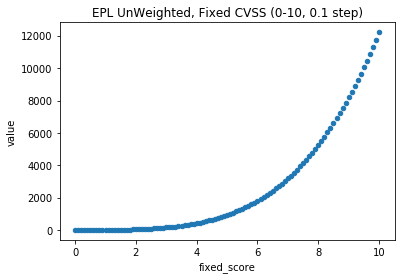

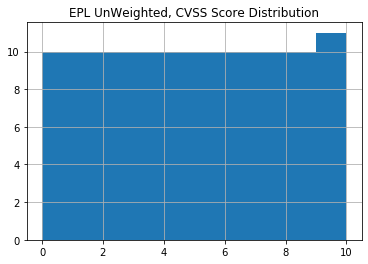

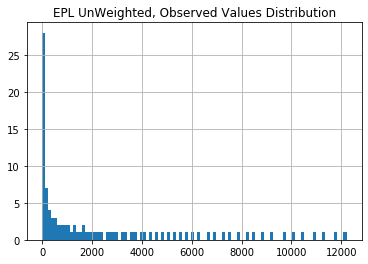

In [106]:



df_eplunnorm_vals = df_eplunnorm[df_eplunnorm.metric=='epl_unnorm']
ax1 = df_eplunnorm_vals.plot('fixed_score', 'value', kind='scatter', title="EPL UnWeighted, Fixed CVSS (0-10, 0.1 step)")
# fig, 
ax2 = df_eplunnorm_vals.hist('fixed_score' )
print(ax2.shape)
ax2[0][0].title.set_text('EPL UnWeighted, CVSS Score Distribution')

ax3 = df_eplunnorm_vals.hist('value', bins=100)
ax3[0][0].title.set_text('EPL UnWeighted, Observed Values Distribution')

In [111]:
df_eplunnorm.metric.unique()

array(['epl_unnorm', 'End to End Runtime', 'Benchmark Run Runtime',
       'Benchmark Prepare Runtime', 'Resource Teardown Runtime',
       'BenchmarkSpec Prepare Runtime', 'Resource Provisioning Runtime'],
      dtype=object)

In [113]:
df_eplunnorm.plot(df_eplunnorm['End to End Runtime'])

KeyError: 'End to End Runtime'

In [114]:
print(df_eplunnorm.columns.tolist())
df_eplunnorm.columns = df_eplunnorm.columns.str.strip()
df_eplunnorm.columns.tolist()

['thedate', 'test', 'value', 'unit', 'labels', 'metric', 'run_uri', 'sample_uri', 'cite_key', 'metric_name', 'metric_summary', 'metric_usage', 'reduced_ag', 'orig_ag', 'fact_graph', 'fixed_score']


['thedate',
 'test',
 'value',
 'unit',
 'labels',
 'metric',
 'run_uri',
 'sample_uri',
 'cite_key',
 'metric_name',
 'metric_summary',
 'metric_usage',
 'reduced_ag',
 'orig_ag',
 'fact_graph',
 'fixed_score']

In [121]:
df_eplunnorm.metric.unique()

array(['epl_unnorm', 'End to End Runtime', 'Benchmark Run Runtime',
       'Benchmark Prepare Runtime', 'Resource Teardown Runtime',
       'BenchmarkSpec Prepare Runtime', 'Resource Provisioning Runtime'],
      dtype=object)

In [139]:
timing_metrics = ['End to End Runtime', 'Benchmark Run Runtime', 'Benchmark Prepare Runtime', 'Resource Teardown Runtime',
       'BenchmarkSpec Prepare Runtime', 'Resource Provisioning Runtime']
df_eplunnorm_times = df_eplunnorm[df_eplunnorm['metric'].str.contains('|'.join(timing_metrics) )]
df_eplunnorm_times_only =  df_eplunnorm_times[['metric', 'value']].copy()
df_eplunnorm_times_only = df_eplunnorm_times_only.groupby('metric')

In [145]:
df_eplunnorm_times_only.describe()

value                                        \
                               count      mean           std           min   
metric                                                                       
Benchmark Prepare Runtime      101.0  0.009188  2.082382e-02  6.076097e-03   
Benchmark Run Runtime          101.0  0.036199  4.037222e-03  2.931046e-02   
BenchmarkSpec Prepare Runtime  101.0  0.000045  1.218839e-05  2.336502e-05   
End to End Runtime             101.0  0.046466  2.069208e-02  3.667545e-02   
Resource Provisioning Runtime  101.0  0.000001  3.886752e-07  9.536743e-07   
Resource Teardown Runtime      101.0  0.000012  6.246076e-06  9.536743e-06   

                                                                       
                                    25%       50%       75%       max  
metric                                                                 
Benchmark Prepare Runtime      0.006371  0.006603  0.006948  0.213210  
Benchmark Run Runtime          0.033381  0.036690  0.038328  0.053516  
BenchmarkSpec Prepare Runtime  0.000039  0.000042  0.000046  0.000120  
End to End Runtime             0.041479  0.044832  0.046068  0.245492  
Resource Provisioning Runtime  0.000001  0.000001  0.000001  0.000004  
Resource Teardown Runtime      0.000010  0.000010  0.000011  0.000056

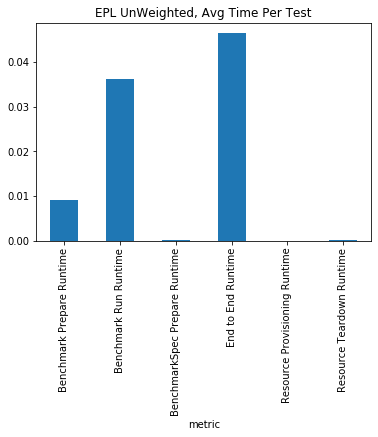

In [158]:
# plot = df_eplunnorm_times_only.plot.pie(y='metric', figsize=(5, 5))
ax1 = df_eplunnorm_times_only['value'].mean().plot(kind='bar')
ax1.title.set_text('EPL UnWeighted, Avg Time Per Test')

In [159]:
print(df_epl.columns.tolist())
df_epl.columns = df_epl.columns.str.strip()
df_epl.columns.tolist()

['thedate', 'test', 'value', 'unit', 'labels', 'metric', 'run_uri', 'sample_uri', 'cite_key', 'metric_name', 'metric_summary', 'metric_usage', 'reduced_ag', 'orig_ag', 'fact_graph', 'fixed_score']


['thedate',
 'test',
 'value',
 'unit',
 'labels',
 'metric',
 'run_uri',
 'sample_uri',
 'cite_key',
 'metric_name',
 'metric_summary',
 'metric_usage',
 'reduced_ag',
 'orig_ag',
 'fact_graph',
 'fixed_score']

In [161]:
timing_metrics = ['End to End Runtime', 'Benchmark Run Runtime', 'Benchmark Prepare Runtime', 'Resource Teardown Runtime',
       'BenchmarkSpec Prepare Runtime', 'Resource Provisioning Runtime']
df_epl_times = df_epl[df_epl['metric'].str.contains('|'.join(timing_metrics) )]
df_epl_times_only =  df_epl_times[['metric', 'value']].copy()
df_epl_times_only = df_epl_times_only.groupby('metric')
df_epl_times_only.describe()

value                                        \
                               count      mean           std           min   
metric                                                                       
Benchmark Prepare Runtime      101.0  0.009662  2.146083e-02  6.205320e-03   
Benchmark Run Runtime          101.0  0.039461  3.737429e-03  3.309155e-02   
BenchmarkSpec Prepare Runtime  101.0  0.000042  6.007117e-06  2.431870e-05   
End to End Runtime             101.0  0.050179  2.155129e-02  4.084206e-02   
Resource Provisioning Runtime  101.0  0.000001  2.441566e-07  9.536743e-07   
Resource Teardown Runtime      101.0  0.000010  9.495521e-07  8.821487e-06   

                                                                       
                                    25%       50%       75%       max  
metric                                                                 
Benchmark Prepare Runtime      0.006459  0.006665  0.007032  0.219481  
Benchmark Run Runtime          0.036682  0.038830  0.041673  0.057513  
BenchmarkSpec Prepare Runtime  0.000039  0.000041  0.000044  0.000080  
End to End Runtime             0.044645  0.046439  0.049961  0.255887  
Resource Provisioning Runtime  0.000001  0.000001  0.000001  0.000002  
Resource Teardown Runtime      0.000010  0.000010  0.000010  0.000014

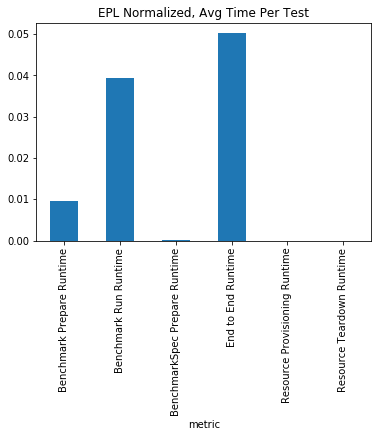

In [170]:
# plot = df_eplunnorm_times_only.plot.pie(y='metric', figsize=(5, 5))
ax1 = df_epl_times_only['value'].mean().plot(kind='bar')
ax1.title.set_text('EPL Normalized, Avg Time Per Test')

## Conclusion